# Imports


In [15]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA


import warnings
warnings.filterwarnings('ignore')

# Loading and cleaning data

In [11]:
# Load data
DATA_PATH = "/Users/teymour/Desktop/cmor438/data/diamond-prices.csv"
df = pd.read_csv(DATA_PATH)

# Clean data (drop NA)
df = df.dropna()

# Data exploration

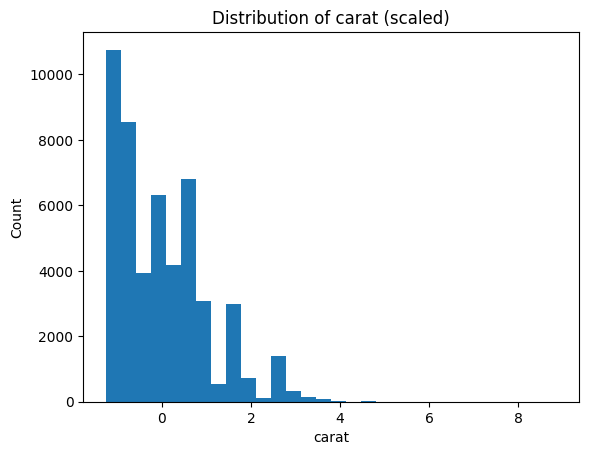

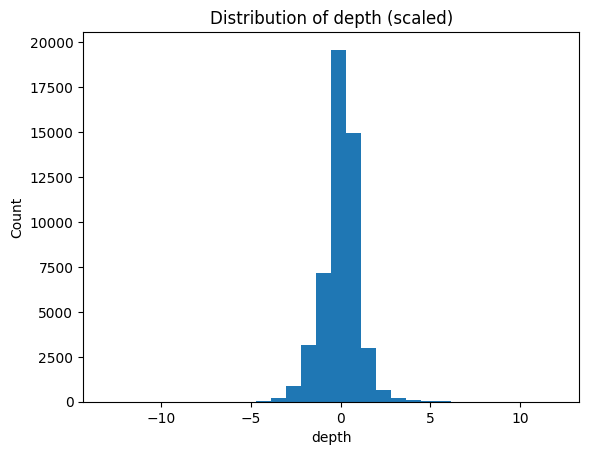

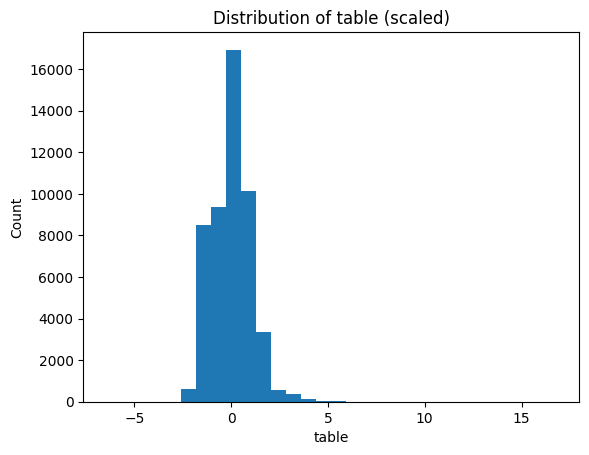

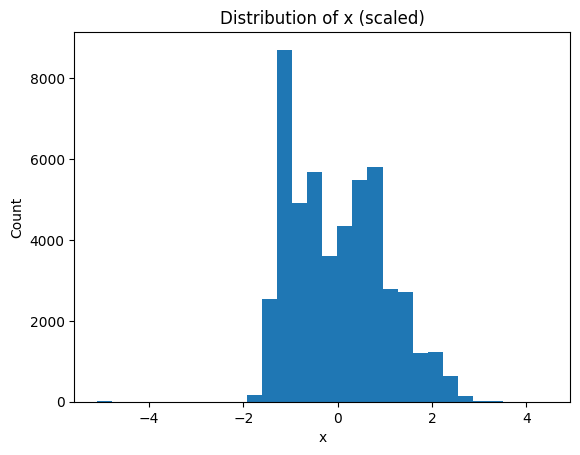

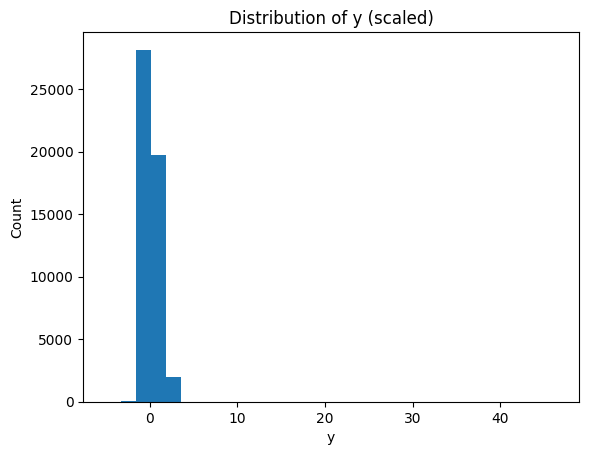

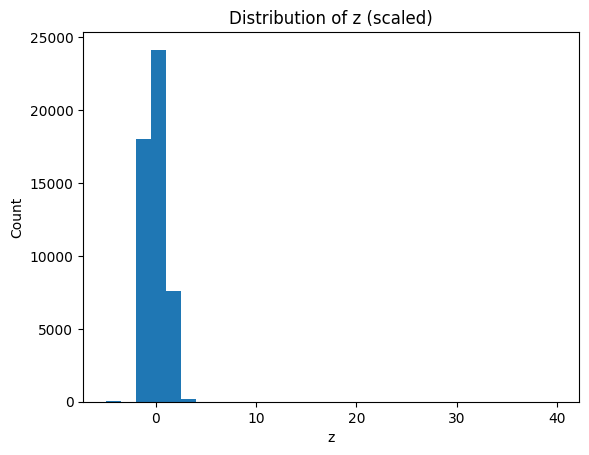

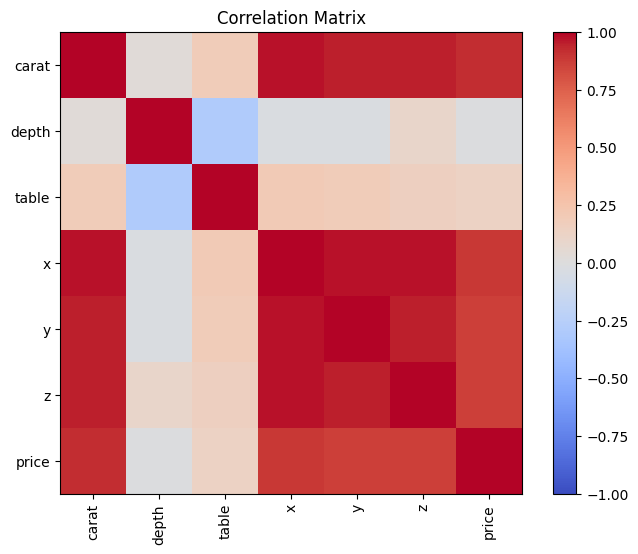

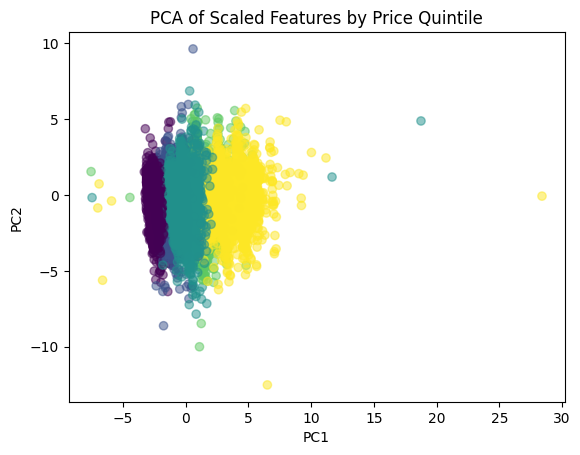

In [16]:
# one-hot encode categorical features
df_enc = pd.get_dummies(df, columns=['cut','color','clarity'], drop_first=True)

# scale numeric features
numeric = ['carat','depth','table','x','y','z']
scaler = StandardScaler()
df_enc[numeric] = scaler.fit_transform(df_enc[numeric])

# distribution of scaled numeric features
for feat in numeric:
    plt.figure()
    plt.hist(df_enc[feat], bins=30)
    plt.title(f'Distribution of {feat} (scaled)')
    plt.xlabel(feat)
    plt.ylabel('Count')
    plt.show()

# correlation matrix heatmap
corr = df_enc[numeric + ['price']].corr()
plt.figure(figsize=(8,6))
plt.imshow(corr, cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar()
plt.xticks(range(len(corr)), corr.columns, rotation=90)
plt.yticks(range(len(corr)), corr.columns)
plt.title('Correlation Matrix')
plt.show()

# PCA projection colored by price quantile
from sklearn.decomposition import PCA
quantiles = pd.qcut(df['price'], 5, labels=False)
pca = PCA(n_components=2)
proj = pca.fit_transform(df_enc[numeric])
plt.figure()
plt.scatter(proj[:,0], proj[:,1], c=quantiles, cmap='viridis', alpha=0.5)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA of Scaled Features by Price Quintile')
plt.show()


# Neural network model

In [17]:
# select features and target
numeric_features = ['carat','depth','table','x','y','z']
categorical_features = ['cut','color','clarity']
X = pd.get_dummies(df[numeric_features + categorical_features], drop_first=True)
y = df['price']

# train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# scale inputs
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# train MLP regressor
model = MLPRegressor(hidden_layer_sizes=(100,50), max_iter=300, random_state=42)
model.fit(X_train_scaled, y_train)

# generate predictions
y_pred = model.predict(X_test_scaled)

# Model evaluation

Buffer Accuracy (±$500): 0.8418
Test MSE: 1086487.84
Test MAE: 306.92
Test R²: 0.9297


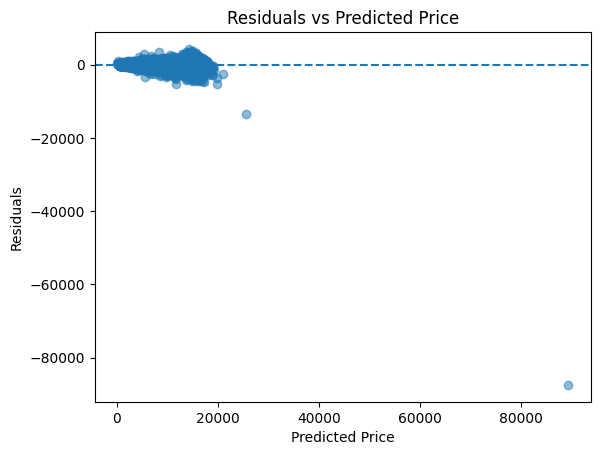

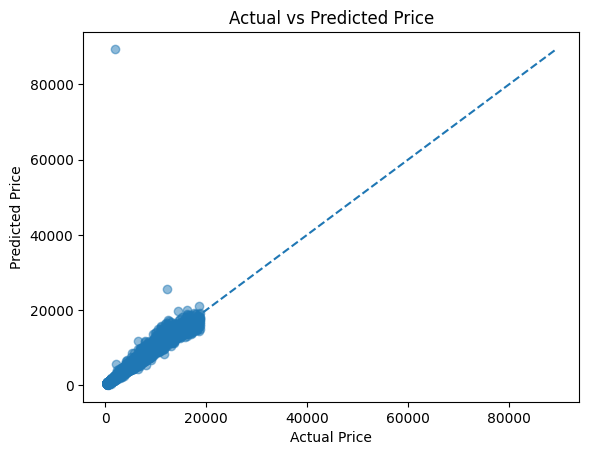

In [18]:
y_true = y_test

mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
r2  = r2_score(y_true, y_pred)
buffer_accuracy = np.mean(np.abs(y_true - y_pred) <= 500)

print(f"Buffer Accuracy (±$500): {buffer_accuracy:.4f}")
print(f"Test MSE: {mse:.2f}")
print(f"Test MAE: {mae:.2f}")
print(f"Test R²: {r2:.4f}")

# residuals vs predicted
residuals = y_true - y_pred
plt.figure()
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(0, linestyle='--')
plt.xlabel("Predicted Price")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted Price")
plt.show()

# actual vs predicted
lims = [min(y_true.min(), y_pred.min()), max(y_true.max(), y_pred.max())]
plt.figure()
plt.scatter(y_true, y_pred, alpha=0.5)
plt.plot(lims, lims, '--')
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs Predicted Price")
plt.show()

# Discussion of results

R² = 0.9297 shows the MLP explains 92.97% of price variance. MAE = 306.92 is the lowest of all models (comparing to linear regression, decision tree, and gradient boosting) and buffer accuracy = 84% is the highest, indicating the network produces tighter central predictions. MLP captures nonlinear combinations of size and shape dimensions more smoothly than a single linear slope but without the piecewise jumps of trees. Squared error is inflated by a few rare extreme outliers where the network misestimates very high prices as seen in the residual plots, reflecting its sensitivity to unusual samples. The neural network’s ability to learn continuous nonlinear patterns yields superior average accuracy and buffer performance compared to linear regression, at the cost of occasional large errors.